In [1]:
import numpy as np
import pandas as pd
import scipy

from IPython.display import clear_output

import sys
sys.path.append('../../../../Documents/GitHub/gustav/src/')

from gustav import ebi, ncbi, nlm, biogrid, nih
from gustav import publications
from gustav import github
from gustav import access_framework
from gustav import mapper

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../general/src/')
from manuscript import export
from manuscript import inout
from manuscript import datasets
from manuscript import tools

from sklearn.metrics import auc
from scipy.stats import fisher_exact
pd.options.display.precision = 3
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 20

In [2]:
taxon = 9606

In [3]:
gene_flavor = 'ou'
ref_genes = datasets.reference_genes(taxon, gene_flavor)

C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_with_delimiter.drop(column, 1).reset_index(),
C:\Users\richa\Documents\GitHub\promising_genes\notebooks\../../../../Documents/GitHub/gustav/src\gustav\utils.py:63: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  joined = joined.drop('helper_index', 1)


In [4]:
ref_literature = datasets.reference_publications(taxon)

In [5]:
agg = []
literature_flavor = 'pubtator_title_or_abstract_in_any_gene2pubmed_paper'

gene2lit = datasets.reference_gene2lit(
    taxon, 
    literature_flavor)
gene2lit = gene2lit[
    gene2lit['gene_ncbi'].isin(ref_genes) & 
    gene2lit['pubmed_id'].isin(ref_literature)
].copy()

In [6]:
%%time
gene2pubmed = gene2lit #ncbi.gene2pubmed(taxon_ncbi=9606)
large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed_dict = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)].value_counts('gene_ncbi').to_dict()

CPU times: total: 125 ms
Wall time: 124 ms


In [7]:
%%time
time_range_of_interest = range(2014, 2019)
taxon_of_interest = 9606

#gene2pubmed = ncbi.gene2pubmed(taxon_ncbi=taxon_of_interest)
#large_pubs = gene2pubmed['pubmed_id'].value_counts()[gene2pubmed['pubmed_id'].value_counts() >= 100].index.values
#gene2pubmed = gene2pubmed[~gene2pubmed['pubmed_id'].isin(large_pubs)]

gene2pubmed = pd.merge(
    gene2pubmed[['gene_ncbi', 'pubmed_id']].drop_duplicates(),
    ncbi.pubmed('main', ['pubmed_id', 'year']).drop_duplicates()
)

agg = dict()
for year in time_range_of_interest:
     agg[year] = gene2pubmed[
         gene2pubmed['year']<year
     ]['gene_ncbi'].value_counts().reindex(ref_genes).fillna(0)

popularity = pd.DataFrame(agg).rename_axis(index='gene_ncbi', columns='year')
popularity = popularity.rank(pct=True).stack().to_frame('popularity_percentile').reset_index()

icite_studies = nih.icite(
    'studies', 
    columns=['pubmed_id', 'year', 'citations_per_year']
).drop_duplicates().dropna()

icite_studies = icite_studies[
    icite_studies['pubmed_id'].isin(gene2pubmed['pubmed_id'])].copy()

citations = icite_studies.set_index(
    'pubmed_id', verify_integrity=True
).groupby('year')['citations_per_year'].rank(pct=True).to_frame('citation_percentile').reset_index()


meshs = ncbi.pubmed('mesh_terms')

# get publications corresponding to introduction of a MeSH term (note: does not consider children of MeSH)
helper = pd.merge(
    gene2pubmed, 
    meshs)
keeper = helper.groupby(['gene_ncbi', 'mesh_terms'])['year'].min().to_frame('year').reset_index()
helper = pd.merge(helper, keeper)

toy = pd.merge(helper, citations)
toy = pd.merge(toy, popularity)

scipy.stats.spearmanr(toy['citation_percentile'], toy['popularity_percentile'])

f = toy.groupby(['pubmed_id', 'mesh_terms']).count().reset_index()
toy = toy[toy['pubmed_id'].isin(f[f['gene_ncbi'] <= 1]['pubmed_id'])]

agg = list()

# for term, data in toy[toy['mesh_terms'].isin(c.index[:100])].groupby(['mesh_terms']):
# for term, data in toy[toy['mesh_terms'].isin(c.reset_index()['index'].sample(n=100).values)].groupby(['mesh_terms']):

for term, data in toy[toy['mesh_terms'].isin(toy['mesh_terms'].unique())].groupby(['mesh_terms']):


    rho, pval = scipy.stats.spearmanr(data['citation_percentile'], data['popularity_percentile'])
    
    agg.append(
        {
            'term': term,
            'rho': rho,
            'pval': pval,
            'n_papers': len(data)
        }
    
    )

results = pd.DataFrame(agg)

C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\scipy\stats\_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


CPU times: total: 1min 4s
Wall time: 1min 6s


In [8]:
mesh_library = nlm.mesh('ui2mn')
disease_ui = mesh_library[mesh_library['mn'].str.startswith('C')]['ui'].values
results['ui'] = results['term'].apply(lambda x: x.split(':')[0])

In [12]:
results['disease_term'] = results['ui'].isin(disease_ui)

In [14]:
results.to_csv('../data/new_gene_introductions_correlation_by_mesh.csv', index=False)

In [9]:
results[(results['pval'] != 0) & (results['n_papers'] > 30) & (results['ui'].isin(disease_ui))].sort_values('pval').head(30)

,term,rho,pval,n_papers,ui
1162,D000236:Adenoma,-0.295,7.091e-06,224,D000236
5113,"D007248:Infertility, Male",-0.323,3.646e-05,157,D007248
6263,D009303:Nasopharyngeal Neoplasms,-0.205,6.695e-05,373,D009303
3720,D004827:Epilepsy,-0.274,7.352e-05,204,D004827
16185,D063646:Carcinogenesis,-0.086,1.315e-04,1991,D063646
8082,D012640:Seizures,-0.277,4.038e-04,159,D012640
4696,"D006528:Carcinoma, Hepatocellular",-0.090,4.178e-04,1518,D006528
2533,D002583:Uterine Cervical Neoplasms,-0.139,4.918e-04,628,D002583
2035,D001749:Urinary Bladder Neoplasms,-0.147,5.623e-04,550,D001749
4182,D005706:Gallbladder Neoplasms,-0.266,1.043e-03,149,D005706


C:\Users\richa\anaconda3\envs\gene_env\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped


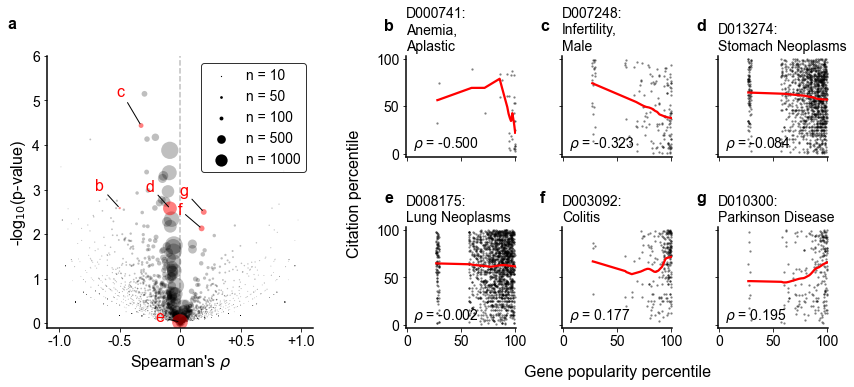

In [10]:
priv_list = \
['D008175:Lung Neoplasms',
 'D010300:Parkinson Disease',
 'D013274:Stomach Neoplasms',
 'D007248:Infertility, Male',
 'D000741:Anemia, Aplastic',
 'D003092:Colitis']

axes = []
gs = mpl.gridspec.GridSpec(nrows=2, ncols=6, 
                           height_ratios=[1,1], 
                           width_ratios=[1,1,0.01,1,1,1],
                           hspace=0.7, wspace=0.5)
fig = plt.figure(figsize=(14,5), constrained_layout=False)


ax_main = fig.add_subplot(gs[0:2, 0:2])
axes.append(ax_main)


results_slice = results[results['ui'].isin(disease_ui)].copy()
results_slice['pval'] = results_slice['pval'].fillna(results_slice[results_slice['pval'] != 0]['pval'].min())

ax_main.scatter(results_slice[~results_slice['term'].isin(priv_list)]['rho'], 
           -np.log10(results_slice[~results_slice['term'].isin(priv_list)]['pval']), 
           s=0.15*results_slice[~results_slice['term'].isin(priv_list)]['n_papers'], 
                alpha=0.25, color='k', linewidth=0)

ax_main.scatter(results_slice[results_slice['term'].isin(priv_list)]['rho'], 
           -np.log10(results_slice[results_slice['term'].isin(priv_list)]['pval']), 
           s=0.15*results_slice[results_slice['term'].isin(priv_list)]['n_papers'], 
                alpha=0.5, zorder=1, color='r', linewidth=0)

ax_main.text(s='a', x=-0.15, y=1.1, 
            transform=ax_main.transAxes, 
            fontdict={'weight':'bold'},
            fontsize=16)

ax_main.tick_params(labelsize=14)
ax_main.set_ylabel('', fontsize=16)
ax_main.set_xlabel('', fontsize=16)
[ax_main.spines[i].set_linewidth(1.5) for i in ax_main.spines]
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_main.set_xticks([-1,-0.5,0,0.5,1], labels=['-1.0','-0.5','0','+0.5','+1.0'])
ax_main.set_ylim([-0.1,6])
ax_main.set_xlabel("Spearman's " + r'$\rho$', fontsize=16)
ax_main.set_ylabel(r'-log$_{10}$(p-value)', fontsize=16)

for size in [10,50,100,500,1000]:
    ax_main.scatter([], [], s=0.15*size, color='k', linewidth=0, label='n = ' + str(size))
leg = ax_main.legend(fontsize=14, frameon=True, loc='upper right')
leg.get_frame().set_edgecolor('k')

priv_slice = results_slice[results_slice['term'].isin(priv_list)]
abc = 'abcdefghijklmnopqrstuvwxyz'
priv_slice = priv_slice.sort_values('rho').reset_index(drop=True)
gs_array = [gs[0, 3], gs[0,4], gs[0, 5],
            gs[1,3], gs[1,4], gs[1,5]]
ax_main.axvline(0, color='k', linestyle='dashed', alpha=0.25, zorder=-1)

for index, row in priv_slice.iterrows():
    x=row['rho']
    y = -np.log10(row['pval'])
    alpha_label = abc[index+1]
    ax_main.annotate(text=alpha_label, fontsize=16,
                     xy = (x,y), 
                     xytext = (x-0.20, y+0.15*y), 
                     arrowprops={'arrowstyle':'-'}, color='r')
    
    ax = fig.add_subplot(gs_array[index])
    axes.append(ax)
    
    mesh_term = row['term']

    _, rho, p, n_papers, ui = results[results['term'] == mesh_term].values[0]


    t = toy[toy['mesh_terms']==mesh_term]
    sns.regplot(x='popularity_percentile', y='citation_percentile', data=100*t, lowess=True,
                scatter_kws={"color": "k", 's': 5, 'alpha':0.5, 'linewidth':0}, 
                line_kws={"color": "red"}, ax=ax)

    #ax.set_title('Publications introducing new genes to\n' + mesh_term + ', 2010-2015', fontsize=16, ha='left', loc='left')

    ax.tick_params(labelsize=14)
    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=16)
    [ax.spines[i].set_linewidth(1.5) for i in ax.spines]
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([-3,103])
    ax.set_xlim([-1,101])
    ax.set_xticks([0,50,100], labels=[])
    ax.set_yticks([0,50,100], labels=[])
    ax.set_title(mesh_term.replace(':', ':\n').replace(', ', ',\n'), fontsize=14, loc='left')
    
    ax.text(s=r'$\rho$ = {:.3f}'.format(rho), 
            x=5, y=1, fontsize=14, 
            backgroundcolor='w',  bbox={'alpha':0.0, 'color':'w'}, va='bottom', ha='left')
    
    ax.text(s=alpha_label, x=-0.20, y=1.25, 
            transform=ax.transAxes, 
            fontdict={'weight':'bold'},
            fontsize=16)

# label yticks and axis
axes[1].set_yticks([0,50,100], labels=[0,50,100])
axes[4].set_yticks([0,50,100], labels=[0,50,100])
fig.text(0.43, 0.5, 'Citation percentile', 
         ha='center', va='center', rotation=90, fontsize=16)

# label xticks and axis
axes[4].set_xticks([0,50,100], labels=[0,50,100])
axes[5].set_xticks([0,50,100], labels=[0,50,100])
axes[6].set_xticks([0,50,100], labels=[0,50,100])

axes[5].set_xlabel('Gene popularity percentile', fontsize=16, labelpad=16)

plt.savefig('../img/supp_fig_new_gene_intros_220829.png', dpi=200, bbox_inches='tight')
plt.savefig('../img/supp_fig_new_gene_intros_220829.pdf', bbox_inches='tight')

export.image('general', p='figures/supp_fig_new_gene_intros_.pdf', date=True)
export.raster_image('general', p='figures/supp_fig_new_gene_intros_.png', date=True, dpi=600)